# VoiceNet — PD vs Healthy (Baseline)


Train a strong baseline for PD vs Healthy using your **voice** feature CSV (e.g., `pd_speech_features.csv`) or a path-based manifest.
- Groups by `subject_id` to avoid leakage.
- Uses `StandardScaler` + `LogisticRegression` (elastic net) wrapped in `CalibratedClassifierCV` for well-calibrated probabilities.
- Saves a reusable **sklearn Pipeline** and predictions.


## Install/verify dependencies

In [5]:

import sys, subprocess, importlib

def ensure(pkg, import_name=None):
    try:
        importlib.import_module(import_name or pkg)
        print(f"{import_name or pkg} OK")
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(import_name or pkg)
        print(f"{import_name or pkg} installed")

ensure("pandas")
ensure("numpy")
ensure("scikit-learn", import_name="sklearn")
ensure("joblib")
ensure("matplotlib")


pandas OK
numpy OK
sklearn OK
joblib OK
matplotlib OK


## Config

In [6]:

from pathlib import Path

# Set to your manifests folder (created by the previous notebook)
MANIFESTS = Path(r"C:\Users\muham\_Projects\PD New\manifests")

VOICE_MANIFEST = MANIFESTS / "voice_manifest_splits.csv"   # created earlier
VOICE_FEATURES = MANIFESTS / "voice_features.csv"          # if using feature-only CSV
OUT_DIR = MANIFESTS / "models"
OUT_DIR.mkdir(exist_ok=True, parents=True)

print("Manifests:", MANIFESTS)
print("Exists:", VOICE_MANIFEST.exists(), VOICE_FEATURES.exists())
print("Models ->", OUT_DIR)


Manifests: C:\Users\muham\_Projects\PD New\manifests
Exists: True True
Models -> C:\Users\muham\_Projects\PD New\manifests\models


## Load data

In [7]:

import pandas as pd
import numpy as np

vm = pd.read_csv(VOICE_MANIFEST)
print(vm.head(3))

# If synthetic feature paths (features://...), join with the full feature table
if (vm["path"].astype(str).str.startswith("features://").any()) and VOICE_FEATURES.exists():
    vf = pd.read_csv(VOICE_FEATURES)
    # try to find the linking key
    lower = {c.lower():c for c in vf.columns}
    key = None
    for cand in ["subject_id","subject","id","name","filename"]:
        if cand in lower:
            key = lower[cand]
            break
    if key is None:
        # fallback: row index mapping (assumes 'features://row_<i>')
        vm["_rowidx"] = vm["path"].str.extract(r"features://row_(\\d+)", expand=False).astype(float)
        vf["_rowidx"] = np.arange(len(vf), dtype=float)
        data = vm.merge(vf, on="_rowidx", how="left", suffixes=("", ""))
    else:
        # long-join on key by normalizing to string
        vm["_k"] = vm["path"].str.replace("features://", "", regex=False).astype(str)
        vf["_k"] = vf[key].astype(str)
        data = vm.merge(vf, on="_k", how="left", suffixes=("", ""))
else:
    data = vm.copy()

# Keep only train/val (ignore 'test' in this notebook)
data = data[data["split2"].isin(["train","val"])].copy()
print("Rows after split filter:", len(data))
print(data[["path","label","subject_id","split2"]].head(3))


  dataset          path  subject_id  label split2
0   voice  features://0           0      1  train
1   voice  features://0           0      1  train
2   voice  features://0           0      1  train
Rows after split filter: 1809
           path  label  subject_id split2
0  features://0      1           0  train
1  features://0      1           0  train
2  features://0      1           0  train


## Build features (numeric-only)

In [9]:
# Select numeric columns as features (excluding target/ids)
import pandas as pd
import numpy as np

y = data["label"].astype(int).to_numpy()

# Group by subject_id if present; otherwise fall back to a stable per-row key (path)
if "subject_id" in data.columns and data["subject_id"].notna().any():
    g = data["subject_id"].astype('string')
    # Fill any missing subject_id with the sample's path so GroupKFold has a valid group
    g = g.fillna(pd.Series(data["path"].astype('string').values, index=data.index))
else:
    g = data["path"].astype('string')
groups = g.to_numpy()

drop_cols = set(["dataset","path","label","subject_id","split","split2","recording_id","source","_rowidx","_k"])
num_cols = [c for c in data.columns if c not in drop_cols and np.issubdtype(data[c].dtype, np.number)]

X = data[num_cols].replace([np.inf,-np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
print("Feature dims:", X.shape)
print("Example feature names:", num_cols[:10])


Feature dims: (1809, 755)
Example feature names: ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter']


## Model — Logistic (Elastic Net) + Calibration

C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 1 AUC=1.000 ACC=0.984


C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 2 AUC=1.000 ACC=0.992


C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 3 AUC=1.000 ACC=1.000


C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 4 AUC=1.000 ACC=1.000


C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\muham\anaconda3\envs\parkinsons_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 5 AUC=0.999 ACC=0.983
\nCV AUC: 0.9998300186979432
CV ACC: 0.9917081260364843
Saved -> C:\Users\muham\_Projects\PD New\manifests\models\voicenet_calibrated.joblib


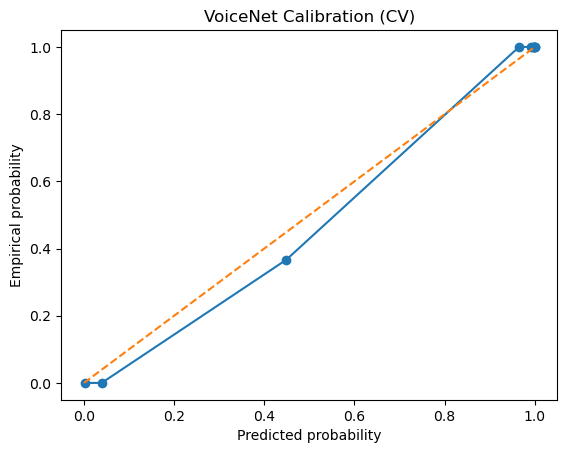

In [10]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt

# Grouped CV
gkf = GroupKFold(n_splits=5)
probs, trues = [], []
for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=2000, penalty="elasticnet", l1_ratio=0.3, C=1.0, solver="saga"))
    ])
    # Fit base
    pipe.fit(X.iloc[tr], y[tr])
    # Calibrate on the same train via CV=3 (isotonic might overfit on small sets; use sigmoid)
    calib = CalibratedClassifierCV(pipe, method="sigmoid", cv=3)
    calib.fit(X.iloc[tr], y[tr])

    p = calib.predict_proba(X.iloc[te])[:,1]
    probs.append(p); trues.append(y[te])
    print(f"Fold {fold+1} AUC={roc_auc_score(y[te], p):.3f} ACC={accuracy_score(y[te], p>0.5):.3f}")

probs = np.concatenate(probs); trues = np.concatenate(trues)
print("\\nCV AUC:", roc_auc_score(trues, probs))
print("CV ACC:", accuracy_score(trues, probs>0.5))

# Fit final on all train+val
final_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=2000, penalty="elasticnet", l1_ratio=0.3, C=1.0, solver="saga"))
])
final_calib = CalibratedClassifierCV(final_pipe, method="sigmoid", cv=5)
final_calib.fit(X, y)

joblib.dump({"pipeline": final_calib, "features": num_cols}, OUT_DIR/"voicenet_calibrated.joblib")
print("Saved ->", OUT_DIR/"voicenet_calibrated.joblib")

# Reliability curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(trues, probs, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical probability")
plt.title("VoiceNet Calibration (CV)")
plt.show()


## Export per-row predictions (train/val)

In [11]:

pred_df = data[["path","subject_id","split2"]].copy()
pred_df["y_true"] = y
pred_df["p_voice"] = probs  # CV predictions
pred_df.to_csv(OUT_DIR/"voicenet_cv_predictions.csv", index=False)
print("Saved ->", OUT_DIR/"voicenet_cv_predictions.csv")


Saved -> C:\Users\muham\_Projects\PD New\manifests\models\voicenet_cv_predictions.csv
